In this Notebook, I am working through the Income Prediction problem associated with the Adult Income Census dataset. The goal is to accurately predict whether or not someone is making more or less than $50,000 a year.

Details of Survey and final_weight parameter and other basic information: https://www.bls.gov/opub/hom/cps/pdf/cps.htm

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3)


In [115]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


# Data Cleaning

we can see that values within features like workclass, occupation are not available

In [116]:
df.rename(columns={'education.num':'education_num', 'marital.status':'marital_status',
                    'capital.loss':'capital_loss', 'hours.per.week':'hours_per_week',
                    'native.country' :'native_country','capital.gain':'capital_gain'}, inplace=True)

In [117]:
# replacing '?' with np.NaN
df.replace(to_replace='?',value=np.NaN, inplace=True)

In [118]:
# lets find out the percentage of nulls in empty values column so that we can correct imputation
empty = {}
for col in df.columns.tolist():
    if df[col].isnull().sum() > 0:  # if any nulls present in the column
        empty[str(col)] = ((df[col].isnull().sum()) / len(df[col])) * 100
empty

{'workclass': 5.638647461687294,
 'occupation': 5.660145572924664,
 'native_country': 1.7904855501980899}

Since the percentage of nan values in a column is very low we can empute them with mode stratergy

In [119]:
mode_value = []
mode_value.append(df['workclass'].mode()[0])
mode_value.append(df['occupation'].mode()[0])
mode_value.append(df['native_country'].mode()[0])
df['workclass'].fillna(mode_value[0],inplace=True)
df['occupation'].fillna(mode_value[1],inplace = True)
df['native_country'].fillna(mode_value[2], inplace=True)

In [120]:
df.isnull().any().sum()

0

In [121]:
map_val = {'<=50K':0,'>50K':1}
df['income']=df.income.map(map_val)

# 3. Correlation

# Modelling:    

Lets use optimal features according to our EDA.

In [123]:
Features = ['age', 'workclass', 'education', 'education_num',
           'marital_status', 'occupation', 'sex',
           'capital_gain', 'capital_loss', 'hours_per_week']

### Encoding of Categorical variables for logistics Regression

In [124]:
from sklearn.preprocessing import LabelEncoder

In [125]:
model = LabelEncoder()
df['workclass'] = model.fit_transform(df['workclass'])
df['education'] = model.fit_transform(df['education'])
df['education_num'] = model.fit_transform(df['education_num'])
df['marital_status'] = model.fit_transform(df['marital_status'])
df['occupation'] = model.fit_transform(df['occupation'])
df['sex'] = model.fit_transform(df['sex'])

In [126]:
workclass_dummy = pd.get_dummies(df['workclass'],prefix='workclass')
education_dummy =  pd.get_dummies(df['education'],prefix='education')
education_num_dummy =  pd.get_dummies(df['education_num'],prefix='education_num')
marital_status_dummy =  pd.get_dummies(df['marital_status'],prefix='marital_status')
occupation_dummy =  pd.get_dummies(df['occupation'],prefix='occupation')
sex_dummy =  pd.get_dummies(df['sex'],prefix='sex')

In [127]:
df_temp = df.copy()
df_temp = pd.concat([df_temp,workclass_dummy.iloc[:,:-1],education_dummy.iloc[:,:-1],
                     education_num_dummy.iloc[:,:-1], marital_status_dummy.iloc[:,:-1],
                     occupation_dummy.iloc[:,:-1], sex_dummy.iloc[:,:-1]], axis=1)

# Lets look for Correlation 

In [153]:
corr_df = df.corr()

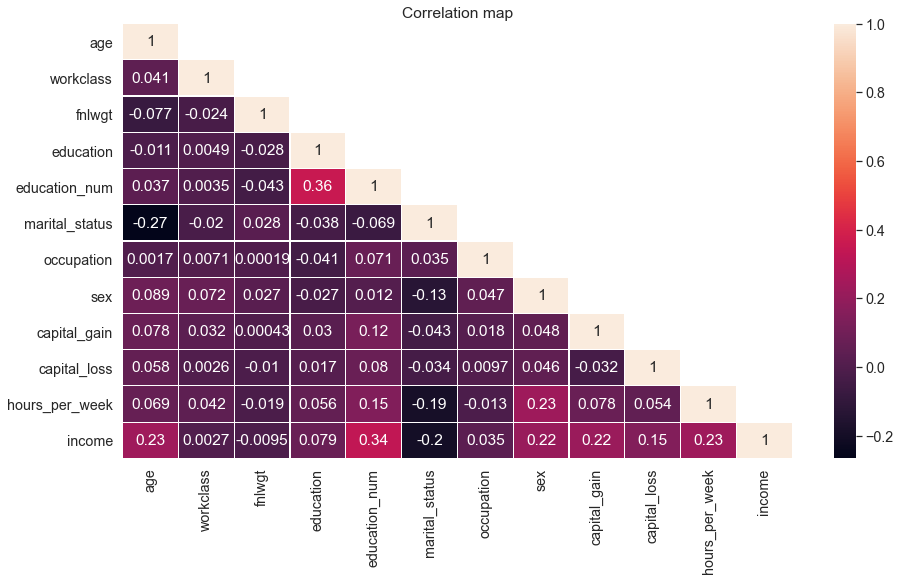

In [152]:
# for reference following code https://cmdlinetips.com/2020/02/lower-triangle-correlation-heatmap-python/

#np.tril(np.ones(corr_df.shape)).astype(np.bool) is used to draw trianle of shape same as corr_df  
#but only lower trianlge values=True

df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))
plt.figure(figsize=(15,8))
sns.heatmap(df_lt, annot=True, linewidth=0.1)
plt.title('Correlation map')
plt.show()

1. from above figure we can see that education is highly correlated with education_num . hence we will remove education_num from features.
2. Also fnlwgt is least correlated with income hence we wont use it too.This was also seen from EDA

In [128]:
from sklearn.model_selection import train_test_split

In [154]:
features_1 = ['age', 'capital_gain', 'capital_loss', 'hours_per_week',
               'workclass_0', 'workclass_1',
               'workclass_2', 'workclass_3', 'workclass_4', 'workclass_5',
               'workclass_6', 'education_0', 'education_1', 'education_2',
               'education_3', 'education_4', 'education_5', 'education_6',
               'education_7', 'education_8', 'education_9', 'education_10',
               'education_11', 'education_12', 'education_13', 'education_14',
                'marital_status_0', 'marital_status_1', 'marital_status_2',
               'marital_status_3', 'marital_status_4', 'marital_status_5',
               'occupation_0','occupation_1', 'occupation_2', 'occupation_3',
                 'occupation_4', 'occupation_5', 'occupation_6', 'occupation_7',
                 'occupation_8', 'occupation_9', 'occupation_10', 'occupation_11',
                 'occupation_12','sex_0']

In [155]:
X = df_temp[features_1]
y = df_temp['income']

In [156]:
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)

(26048, 46)
(6513, 46)


In [157]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix


In [158]:
def plot_confusion_matrix(y_true, y_predicted, classes, normalize=True, title=None, cmap=plt.cm.Blues):
    #      """
    #         This function prints and plots the confusion matrix.
    #         Normalization can be applied by setting `normalize=True`.
    #       """
    if not title:
        if normalize == True:
            title = "Normalized confusion matirx"
        else:
            title = " Confusion matrix without Normalization"
            
    # conmpute confusion matrix
    cm = confusion_matrix(y_true, y_predicted)
    if normalize == True:
        cm = cm.astype('float') / cm.sum(axis=1) 
        
    df_cm = pd.DataFrame(
                cm, index=classes, columns=classes)
    
    fig = plt.figure(figsize=(8,5))
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f', cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix must be integers")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, fontsize=12)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    return fig
    
    

In [159]:
def train_and_evaluate (clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    
    print('Accuracy on train set')
    print(clf.score(X_train, y_train))
    print('Accuracy on test set')
    print(clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    classes = np.unique(y_train).tolist()
    print("Classification Report")
    print(metrics.classification_report(y_test, y_pred))
    
    plot_confusion_matrix(y_test, y_pred, classes, normalize=False)
    
    plt.show()

In [160]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

min_max_scaler = MinMaxScaler()


## Logistics Regression

In [161]:
from sklearn.linear_model import LogisticRegression

In [162]:
log_model = LogisticRegression(penalty='none', max_iter=10000)
scale_lr_pipeline = Pipeline(steps = [('scaler', min_max_scaler), ('model', log_model)])

In [163]:
scale_lr_pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='none', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Accuracy on train set
0.8503531941031941
Accuracy on test set
0.8522954091816367
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4943
           1       0.74      0.59      0.66      1570

    accuracy                           0.85      6513
   macro avg       0.81      0.76      0.78      6513
weighted avg       0.85      0.85      0.85      6513



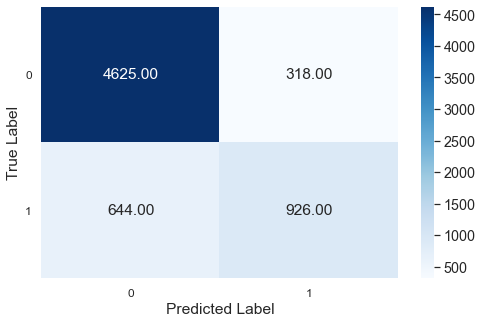

In [164]:
train_and_evaluate (scale_lr_pipeline, X_train, X_test, y_train, y_test)

## Logistics Regression with Regularization

In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [31]:
log_model = LogisticRegression(penalty='l1', max_iter=10000,solver='saga')
# saga solver for min-max preprocesssing

In [32]:
C_val_exponents = np.linspace(2,-3, 6)
C_vals = np.float(10)**C_val_exponents
C_vals

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [291]:
k_folds = KFold(n_splits=4,shuffle=True, random_state=1)

In [292]:
scale_lr_pipeline = Pipeline(steps = [('scaler', min_max_scaler), ('model', log_model)])

In [293]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X,Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)
    pipeline.set_params(model__max_iter = 10000)
    
    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X.iloc[train_index,:], X.iloc[test_index,:]
            y_cv_train, y_cv_test = Y.iloc[train_index], Y.iloc[test_index]

            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [294]:
cv_train_roc_score, cv_test_roc_score, cv_test_roc_auc_curve = \
            cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train,y_train) 

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation')

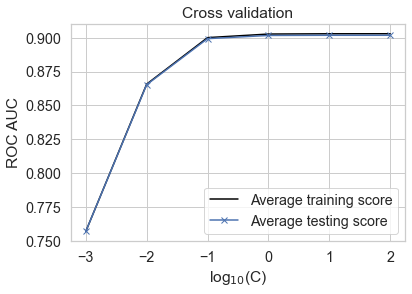

In [295]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_score, axis=0),
         '-0', label="Average training score")
plt.plot(C_val_exponents, np.mean(cv_test_roc_score, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation')

from the Graph above we can say that with C=0,1,2  model works better. We will choose C=1, since the regularisation gives divide by error   

In [298]:
log_model = LogisticRegression(penalty='l1',C=1, max_iter=10000, solver='saga')
scale_lr_pipeline = Pipeline(steps = [('scaler', min_max_scaler), ('model', log_model)])

Accuracy on train set
0.8503531941031941
Accuracy on test set
0.8519883310302472
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4943
           1       0.74      0.59      0.66      1570

    accuracy                           0.85      6513
   macro avg       0.81      0.76      0.78      6513
weighted avg       0.85      0.85      0.85      6513



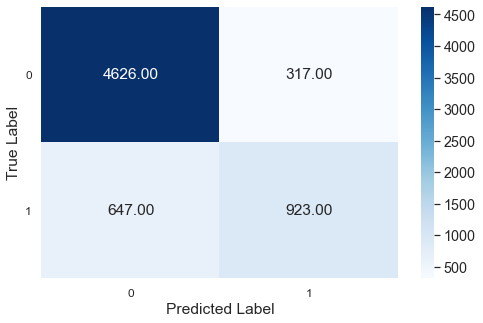

In [299]:
train_and_evaluate (scale_lr_pipeline, X_train, X_test, y_train, y_test)

In [287]:
log_pred = log_model.predict(X_test)

From L2 with and L2 without Regularization we can see that our Model provides better Accuracy without Regularization

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [165]:
Features = ['age', 'workclass', 'education', 'marital_status', 
            'occupation', 'sex','capital_gain', 'capital_loss', 'hours_per_week']

X = df[Features]
y = df['income']
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)

(26048, 9)
(6513, 9)


right now i am choosing random parameters for tree. will do Cross Validation after this and find out optimised values

In [166]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini',max_depth=12, verbose=1, 
                          random_state = True, warm_start=False, oob_score =True)

I decided to skip Pipeline method because that wasn't helping in increasing scores.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.5s finished


Accuracy on train set


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8773418304668305
Accuracy on test set


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


0.8654997696913864
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4943
           1       0.80      0.60      0.68      1570

    accuracy                           0.87      6513
   macro avg       0.84      0.77      0.80      6513
weighted avg       0.86      0.87      0.86      6513



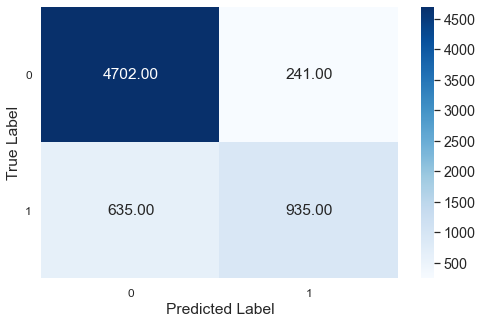

In [167]:
train_and_evaluate(rf, X_train, X_test, y_train, y_test)

We can see that our accuracy increased by 1% .**Now, Lets try Cross Validation on Random Forest**

here since the distribution of samples class is not same we will use Stratified KFold

In [168]:
from sklearn.model_selection import GridSearchCV

In [169]:
n_params = {'n_estimators':[100, 200, 400, 600, 800, 1000, 2000], 'max_depth':[2, 4,6,8,10,11,12]}

In [170]:
rf_cv = GridSearchCV(rf, param_grid=n_params, scoring='roc_auc',
                        n_jobs=None, refit=True, cv=4, verbose=1,
                        pre_dispatch=None, error_score=np.nan, return_train_score=True)

In [171]:
rf_cv.fit(X_train, y_train)

Fitting 4 folds for each of 49 candidates, totalling 196 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_j

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Pa

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   17.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    3.6s finished
[Parallel(

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   23.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   21.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Us

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=12,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=True, random_state=True,
                                   

In [172]:
cv_rf_results_df = pd.DataFrame(rf_cv.cv_results_)
cv_rf_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.664825,0.011221,0.056749,0.004891,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.864015,0.852845,0.864827,0.859488,0.860294,0.004757,49,0.859887,0.863186,0.861072,0.859232,0.860844,0.001504
1,1.415446,0.085506,0.103651,0.019113,2,200,"{'max_depth': 2, 'n_estimators': 200}",0.864091,0.854494,0.863587,0.859310,0.860371,0.003868,48,0.860525,0.864561,0.861730,0.858966,0.861445,0.002048
2,3.288212,0.220289,0.202341,0.034812,2,400,"{'max_depth': 2, 'n_estimators': 400}",0.865099,0.855841,0.864967,0.864108,0.862504,0.003866,46,0.861632,0.866115,0.863338,0.862304,0.863347,0.001710
3,4.512506,0.512825,0.267278,0.015496,2,600,"{'max_depth': 2, 'n_estimators': 600}",0.864420,0.855623,0.864971,0.863863,0.862219,0.003829,47,0.861386,0.865684,0.863190,0.862318,0.863144,0.001599
4,6.418082,0.984557,0.454297,0.069385,2,800,"{'max_depth': 2, 'n_estimators': 800}",0.865776,0.856726,0.866039,0.864912,0.863363,0.003855,43,0.862567,0.866650,0.864276,0.863572,0.864266,0.001504
5,8.415198,0.952175,0.523475,0.114646,2,1000,"{'max_depth': 2, 'n_estimators': 1000}",0.865914,0.856946,0.866016,0.862294,0.862793,0.003693,45,0.862656,0.867052,0.864410,0.862094,0.864053,0.001931
6,14.855595,0.479561,1.047193,0.215574,2,2000,"{'max_depth': 2, 'n_estimators': 2000}",0.865806,0.857533,0.866105,0.862020,0.862866,0.003474,44,0.863205,0.867602,0.864575,0.862175,0.864389,0.002041
7,0.953562,0.141995,0.066889,0.009486,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.887592,0.877390,0.883371,0.885220,0.883393,0.003775,36,0.884679,0.887284,0.884413,0.883439,0.884954,0.001422
8,1.888038,0.252347,0.129328,0.036782,4,200,"{'max_depth': 4, 'n_estimators': 200}",0.886830,0.876252,0.883237,0.886208,0.883132,0.004198,40,0.883723,0.886753,0.884332,0.884215,0.884756,0.001176
9,3.245869,0.044181,0.204254,0.005503,4,400,"{'max_depth': 4, 'n_estimators': 400}",0.887047,0.876188,0.883166,0.886015,0.883104,0.004238,42,0.883990,0.886759,0.884445,0.883625,0.884705,0.001221


In [183]:
cv_rf_results_df.tail()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
44,5.434619,0.035322,0.367473,0.001991,12,400,"{'max_depth': 12, 'n_estimators': 400}",0.920444,0.910792,0.914418,0.915632,0.915322,0.003452,5,0.947199,0.948804,0.947796,0.947588,0.947846,0.000593
45,8.458242,0.348936,0.587598,0.039533,12,600,"{'max_depth': 12, 'n_estimators': 600}",0.920520,0.910835,0.914361,0.915648,0.915341,0.003471,4,0.947284,0.948653,0.947739,0.947653,0.947832,0.000504
46,10.986039,0.117631,0.747456,0.021066,12,800,"{'max_depth': 12, 'n_estimators': 800}",0.920485,0.910905,0.914348,0.915635,0.915343,0.003436,3,0.947292,0.948576,0.947802,0.947720,0.947848,0.000463
47,13.738576,0.128692,0.965794,0.042237,12,1000,"{'max_depth': 12, 'n_estimators': 1000}",0.920512,0.910977,0.914511,0.915650,0.915413,0.003411,2,0.947313,0.948574,0.947878,0.947782,0.947887,0.000451
48,27.730550,0.162025,1.946311,0.116855,12,2000,"{'max_depth': 12, 'n_estimators': 2000}",0.920580,0.910904,0.914617,0.915698,0.915450,0.003455,1,0.947293,0.948627,0.947932,0.947771,0.947906,0.000478


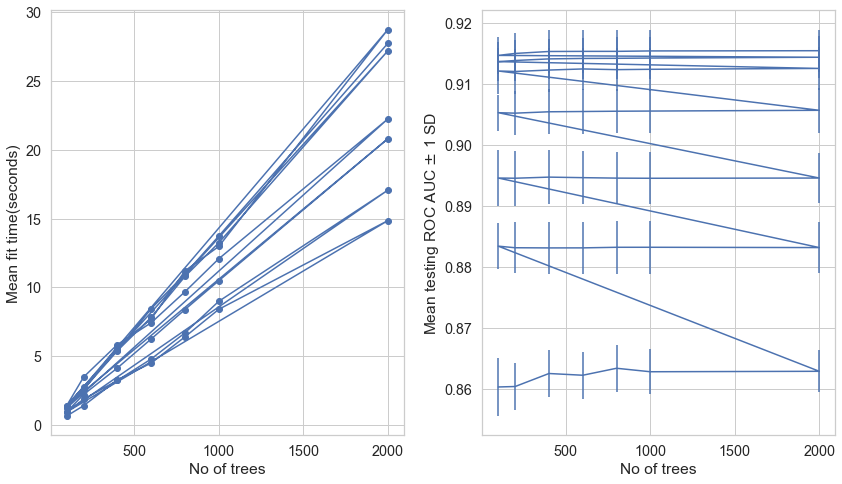

In [185]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,7))
axes[0].plot(cv_rf_results_df['param_n_estimators'],
             cv_rf_results_df['mean_fit_time'], '-o')
axes[0].set_xlabel('No of trees')
axes[0].set_ylabel('Mean fit time(seconds)')

axes[1].errorbar(cv_rf_results_df['param_n_estimators'],
                cv_rf_results_df['mean_test_score'],
                yerr=cv_rf_results_df['std_test_score'])
axes[1].set_xlabel('No of trees')
axes[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SD ')
plt.tight_layout()

In [174]:
rf_cv.best_params_

{'max_depth': 12, 'n_estimators': 2000}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   47.9s finished


Accuracy on train set


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9469057125307125
Accuracy on test set


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8656533087670812


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    2.9s finished


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4943
           1       0.76      0.65      0.70      1570

    accuracy                           0.87      6513
   macro avg       0.83      0.79      0.81      6513
weighted avg       0.86      0.87      0.86      6513



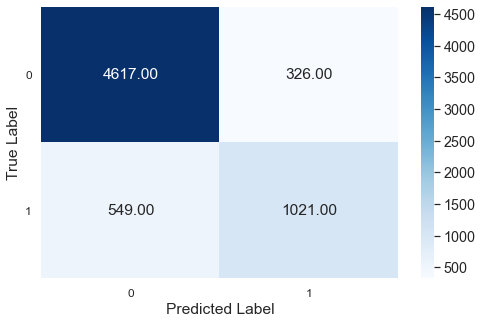

In [194]:
rf = RandomForestClassifier(n_estimators=2000, criterion='gini',max_depth=20, verbose=1, 
                          random_state = True, warm_start=False, oob_score =True)
train_and_evaluate(rf, X_train, X_test, y_train, y_test)

In [175]:
feat_imp_df = pd.DataFrame({'Feature_name':Features,
                            'Importance':rf_cv.best_estimator_.feature_importances_})
feat_imp_df.sort_values(by='Importance', ascending=False)

,Feature_name,Importance
3,marital_status,0.251056
6,capital_gain,0.250448
0,age,0.123486
2,education,0.101092
7,capital_loss,0.082094
8,hours_per_week,0.080667
4,occupation,0.055646
5,sex,0.033453
1,workclass,0.022059


## K-Nearest Neighbour 

In [179]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

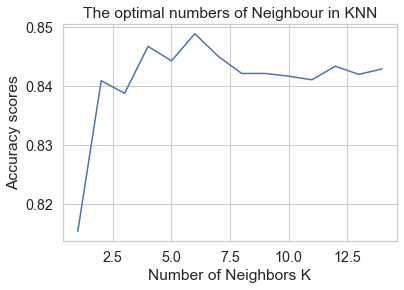

Accuracy on train set
0.8596821253071253
Accuracy on test set
0.8420082911100876
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4943
           1       0.70      0.60      0.65      1570

    accuracy                           0.84      6513
   macro avg       0.79      0.76      0.77      6513
weighted avg       0.84      0.84      0.84      6513



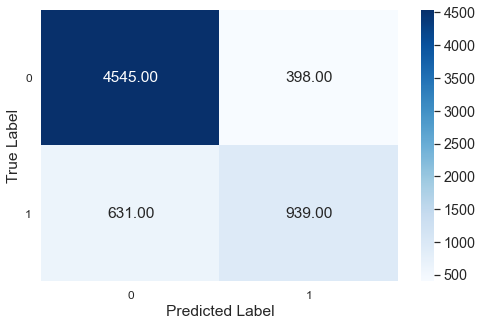

In [180]:
neigh = KNeighborsClassifier(n_neighbors=5)
k_accuracy=[]

for k in range(1,15):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train,y_train)
    y_pred = neigh.predict(X_test)
    k_accuracy.append(accuracy_score(y_test, y_pred))
    
plt.plot(range(1,15), k_accuracy)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy scores')
plt.title('The optimal numbers of Neighbour in KNN')
plt.show()



Accuracy on train set
0.8743857493857494
Accuracy on test set
0.8450790726239829
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4943
           1       0.70      0.63      0.66      1570

    accuracy                           0.85      6513
   macro avg       0.79      0.77      0.78      6513
weighted avg       0.84      0.85      0.84      6513



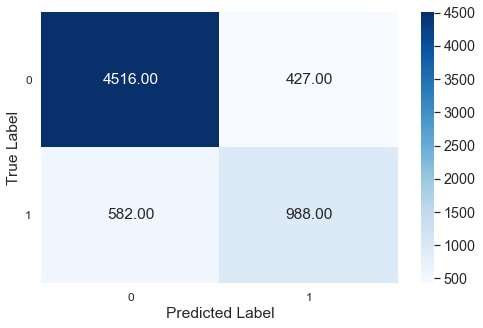

In [189]:
neigh = KNeighborsClassifier(n_neighbors=7)
train_and_evaluate(neigh, X_train, X_test, y_train, y_test)

From scores we can see that Train data is overfitting on dataset.

**Hence Random Forest with n_estimators=2000, max_depth =20 is preferable model in this case with 86.5 % accuracy**